# Using Tabulated Potentials

In some cases, it may be useful to specify the potentials defining the bonded and/or non-bonded interactions in a system as lists of tabulated values to be interpolated.  Although custom potentials are often most convenient to define in OpenMM by passing analytical expressions to, *e.g.*, `CustomNonbondedForce` for pairwise potentials, the tabular approach can be useful for efficient approximation of potentials that would otherwise be expensive to evaluate, applications related to coarse-grained modeling, *etc.*

In this example, we will consider a binary mixture of particles interacting with a potential having a truncated and shifted Gaussian functional form
$$u_{ij}(r)=\begin{cases}\epsilon_{ij}\big[(-\alpha_{ij}r^2)-\exp(-\alpha_{ij}r_{\mathrm{cut}}^2)\big]&r<r_{\mathrm{cut}}\\0&r\ge r_{\mathrm{cut}}\end{cases}.$$
We will simulate such a mixture by defining a `CustomNonbondedForce` that specifies this potential analytically, and then demonstrate two ways to define tabulated potentials to achieve the same result.

## Setup

To begin, we will import packages necessary for the examples below, and define some constants that will be used throughout:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openmm
import openmm.unit as u
import scipy.interpolate as interp
import time

In [2]:
# Numbers of particles of types A and B for potential energy test.
N_A = 200
N_B = 100

# We will use a cubic periodic box.
BOX = np.diag([10.0, 10.0, 10.0]) * u.nanometer

# Define epsilon_ij and alpha_ij.  These matrices should be symmetric.
EPS = np.array([
    [1.1, 0.8],
    [0.8, 1.5],
]) * u.kilojoule_per_mole
ALPHA = np.array([
    [2.0, 0.7],
    [0.7, 1.2],
]) * u.nanometer ** -2

# Define a cutoff radius for the potential.
R_CUT = 3.0 * u.nanometer

# Specify the number of evaluation points for the tabulated functions.  This is
# quite low and will not give a particularly accurate approximation of the
# function we are fitting.  However, it will allow us to easily see the effect
# of increasing the resolution.
N_TABLE = 10

# Set some default options for integrating the system.
TEMP = 300.0 * u.kelvin
LANGEVIN_DAMP = 1.0 / u.picosecond
LANGEVIN_STEP = 0.01 * u.picosecond
N_STEP_EQUIL = 100000
N_STEP_SAMP = 100
N_SAMP_PROD = 1000

Let us define a Python function to evaluate the potential at a distance $r$ between particles of types $i$ and $j$ (here $i,j\in\{0,1\}$ where $0$ corresponds to type A and $1$ to type B).

In [3]:
U_CUT = EPS * np.exp(-ALPHA * R_CUT * R_CUT)

def u_ij(r, i, j):
    return EPS[i, j] * np.exp(-ALPHA[i, j] * r * r) - U_CUT[i, j] if r < R_CUT else 0.0 * u.kilojoule_per_mole

The pair potentials between the different particle types appear as follows:

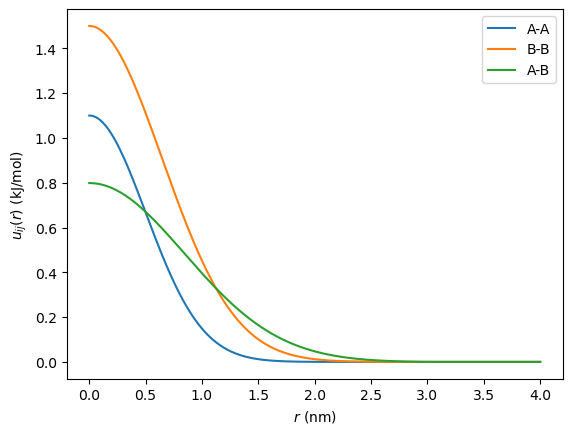

In [4]:
plot_r = np.linspace(0.0, R_CUT.value_in_unit(u.nanometer) + 1.0, 1001) * u.nanometer
plot_u_aa = np.array([u_ij(r, 0, 0).value_in_unit(u.kilojoule_per_mole) for r in plot_r])
plot_u_bb = np.array([u_ij(r, 1, 1).value_in_unit(u.kilojoule_per_mole) for r in plot_r])
plot_u_ab = np.array([u_ij(r, 0, 1).value_in_unit(u.kilojoule_per_mole) for r in plot_r])

plt.plot(plot_r, plot_u_aa, label="A-A")
plt.plot(plot_r, plot_u_bb, label="B-B")
plt.plot(plot_r, plot_u_ab, label="A-B")
plt.xlabel("$r\\ (\\mathrm{nm})$")
plt.ylabel("$u_{ij}(r)\\ (\\mathrm{kJ/mol})$")
plt.legend()
plt.show()

## Analytical potential evaluation

Before demonstrating how to set up tabulated potentials in OpenMM, we will create a reference analytical implementation of this potential.  We will first define a function to create a test system containing particles with no interactions between them, and another function to create a context and an integrator for a system.

In [5]:
def create_system(n_a, n_b):
    system = openmm.System()
    system.setDefaultPeriodicBoxVectors(*BOX)
    for i in range(n_a + n_b):
        system.addParticle(1.0 * u.dalton)
    return system

def create_context_integrator(system):
    integrator = openmm.LangevinMiddleIntegrator(TEMP, LANGEVIN_DAMP, LANGEVIN_STEP)
    context = openmm.Context(system, integrator)

    return context, integrator

Next, we will define a function to add a force to such a system that implements our potential:

In [6]:
def add_force_analytical(system, n_a, n_b):
    # Create the force.  We will create arrays "eps", "alpha", and "ucut", indexed by a per-particle parameter "type".
    force = openmm.CustomNonbondedForce("eps(type1, type2) * exp(-alpha(type1, type2) * r * r) - ucut(type1, type2)")
    force.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)
    force.setCutoffDistance(R_CUT)

    # Pass coefficient value arrays into the force.
    force.addTabulatedFunction("eps", openmm.Discrete2DFunction(2, 2, EPS.flatten(order="F")))
    force.addTabulatedFunction("alpha", openmm.Discrete2DFunction(2, 2, ALPHA.flatten(order="F")))
    force.addTabulatedFunction("ucut", openmm.Discrete2DFunction(2, 2, U_CUT.flatten(order="F")))
    force.addPerParticleParameter("type")

    # Add particles.  Specify the appropriate type of each particle.
    for i in range(n_a):
        force.addParticle([0])
    for i in range(n_b):
        force.addParticle([1])

    system.addForce(force)

There are a few subtleties worth mentioning in this implementation.  First, the coefficient arrays should be symmetric, since the order of the particle types in a pair of particles is arbitrary and should not affect the energy.  Second, OpenMM's multidimensional `TabulatedFunction`s take their data as a flat array in *column-major* order (*i.e.*, "Fortran order").  The default for flattening a NumPy array is *row-major* order (*i.e.*, "C order"), hence the specification of `order="F"` to request column-major order instead: although this will not matter in this particular case since the arrays are symmetric, it will be **critically important to specify correctly** in later examples!  Finally, OpenMM converts values to its [default units](http://docs.openmm.org/latest/userguide/theory/01_introduction.html#units) of nm, ps, amu, kJ/mol, *etc.* before they enter tabulated functions and custom function expressions:

In [7]:
openmm.Discrete1DFunction([1.0 * u.kilocalorie_per_mole]).getFunctionParameters()

(4.184,)

These default units are self-consistent, and so results should be valid as long as the custom expressions given to OpenMM are dimensionally consistent.  **It is the responsibility of the user** to ensure that they are dimensionally consistent, as the OpenMM Python wrapper does not verify this automatically.

We will test our systems by evaluating the pair potentials in OpenMM and comparing against the reference implementation, and by running short simulations of systems of particles.  We will define two different test functions for each of these tests.

In [8]:
def test_evaluate_potential(add_force, **kwargs):
    for n_a, n_b, label, ref_u_ij in ((2, 0, "A-A", plot_u_aa), (0, 2, "B-B", plot_u_bb), (1, 1, "A-B", plot_u_ab)):
        system = create_system(n_a, n_b)
        add_force(system, n_a, n_b, **kwargs)
        context, integrator = create_context_integrator(system)

        # Evaluate the pair potential by placing a particle at [0, 0, 0] and another at [r, 0, 0].
        test_u_ij = []
        for r in plot_r:
            xyz = np.zeros((2, 3)) * u.nanometer
            xyz[1, 0] = r
            context.setPositions(xyz)
            test_u_ij.append(context.getState(energy=True).getPotentialEnergy().value_in_unit(u.kilojoule_per_mole))
        test_u_ij = np.array(test_u_ij)

        # At r = 0, the energy may be NaN, so exclude this point from consideration.
        err_u_ij = test_u_ij[1:] - ref_u_ij[1:]
        plt.semilogy(plot_r[1:], np.abs(err_u_ij), label=label)

        print(f"Maximum error for {label}: {np.amax(np.abs(err_u_ij)):.3e} kJ/mol")

    plt.xlabel("$r\\ (\\mathrm{nm})$")
    plt.ylabel("Error in $u_{ij}(r)\\ (\\mathrm{kJ/mol})$")
    plt.ylim(1e-12, 1)
    plt.legend()
    plt.gcf().set_figheight(2)
    plt.show()

In [9]:
def test_run_dynamics(add_force, **kwargs):
    system = create_system(N_A, N_B)
    add_force(system, N_A, N_B, **kwargs)
    context, integrator = create_context_integrator(system)

    # Place particles in random positions and equilibrate.
    context.setPositions(np.random.uniform(size=(N_A + N_B, 3)) * np.diag(BOX.value_in_unit(u.nanometer)) * u.nanometer)
    integrator.step(N_STEP_EQUIL)

    energies = []

    # Periodically measure the potential energy.
    start_time = time.perf_counter()
    for i in range(N_SAMP_PROD):
        integrator.step(N_STEP_SAMP)
        energies.append(context.getState(energy=True).getPotentialEnergy().value_in_unit(u.kilojoule_per_mole))
    end_time = time.perf_counter()

    print(f"Average potential energy: {np.mean(energies):.6e} kJ/mol")
    print(f"Time for {N_SAMP_PROD * N_STEP_SAMP} steps: {end_time - start_time:.3f} s")

Running the first test shows that the potential computed by OpenMM agrees with the pure Python implementation (within the limits of single precision used by OpenMM).  We will compare the reference value and timing from the second test with values from implementations of our potential using tabulated functions.

Maximum error for A-A: 1.248e-07 kJ/mol
Maximum error for B-B: 2.221e-07 kJ/mol
Maximum error for A-B: 1.112e-07 kJ/mol


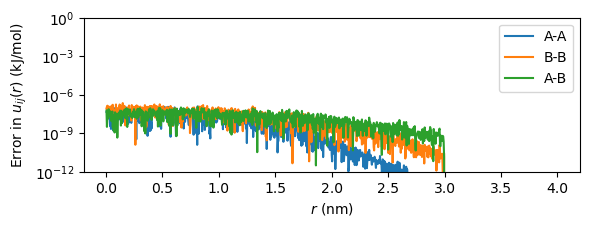

Average potential energy: 2.005794e+02 kJ/mol
Time for 100000 steps: 6.079 s


In [10]:
test_evaluate_potential(add_force_analytical)
test_run_dynamics(add_force_analytical)

## Tabulated potentials with `Continuous3DFunction`

An ideal tabulated function will take two integer arguments defining the particle types, and one floating-point argument specifying a pairwise distance, and return an energy (like our `u_ij` defined above).  Although OpenMM does not offer a `TabulatedFunction` with this exact behavior, it is possible to use `Continuous3DFunction` to accomplish the same effect.  By evaluating it along the particle type dimensions only at integer particle type indices, the interpolation along these dimensions will have no effect, and the only interpolation that will take place will be along the distance dimension.  This is somewhat inefficient as calculations for the interpolation along all three axes will still take place, but it is the most straightforward way to set up a tabulated potential.

We first define a function to make an $n_{\mathrm{type}}\times n_{\mathrm{type}}\times n_{\mathrm{table}}$ table, where $n_{\mathrm{type}}=2$ is the number of particle types and $n_{\mathrm{table}}$ is the number of tabulated points.  For the purposes of this example, we use our analytical potential to generate the table entries.  Since the analytical expression is straightforward to evaluate directly, there is not much benefit to replacing it with a tabulated function here.  However, the tabulated function approach is completely general and the values can come from any arbitrary source (computed from an expensive-to-evaluate model, read in from an external file, generated by another program or library, *etc.*)

In [11]:
def make_table(n_table):
    # Evaluate our potential at the table points.
    r_table = np.linspace(0.0, R_CUT.value_in_unit(u.nanometer), n_table) * u.nanometer
    return np.array([[[u_ij(r, i, j).value_in_unit(u.kilojoule_per_mole) for r in r_table] for j in range(2)] for i in range(2)])

The setup for the force is similar to `add_force_analytical` above.  However, here, the force expression is simply a single table evaluation, and the precomputed table is passed to the force.  Note that we specify `xmin` and `xmax` of the `Continuous3DFunction` as $0$ and $1$ ($0$ and $n_{\mathrm{type}}-1$), respectively, and likewise for `ymin` and `ymax`, since these are the dimensions corresponding to the particle types.  The table should be set up such that `zmin` and `zmax` are $0$ and $r_{\mathrm{cut}}$, respectively, so that all evaluations of the tabulated function that contribute to the energy of the system will fall within the table range.

In [12]:
def add_force_tabulated_c3d(system, n_a, n_b, n_table):
    # Create the force.  We will use a single tabulated function "table".
    force = openmm.CustomNonbondedForce("table(type1, type2, r)")
    force.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)
    force.setCutoffDistance(R_CUT)

    # Pass function values into the force.  Here it is critical to specify column-major order!
    force.addTabulatedFunction("table", openmm.Continuous3DFunction(2, 2, n_table, make_table(n_table).flatten(order="F"), 0, 1, 0, 1, 0.0 * openmm.unit.nanometer, R_CUT))
    force.addPerParticleParameter("type")

    # Add particles.  Specify the appropriate type of each particle.
    for i in range(n_a):
        force.addParticle([0])
    for i in range(n_b):
        force.addParticle([1])

    system.addForce(force)

The table matches the reference function exactly at the evaluation points, but deviates from it to some extent in between them.  In this case, the average energy from the dynamics run still matches the reference implementation well.

Maximum error for A-A: 2.844e-02 kJ/mol
Maximum error for B-B: 2.180e-02 kJ/mol
Maximum error for A-B: 6.495e-03 kJ/mol


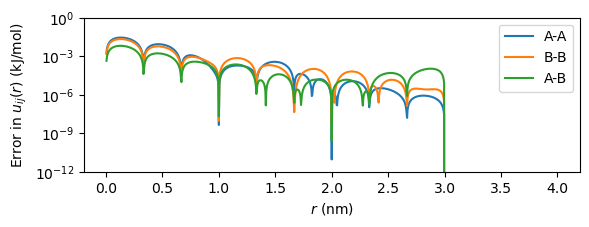

Average potential energy: 2.005477e+02 kJ/mol
Time for 100000 steps: 6.475 s


In [13]:
test_evaluate_potential(add_force_tabulated_c3d, n_table=N_TABLE)
test_run_dynamics(add_force_tabulated_c3d, n_table=N_TABLE)

It is possible to use more table points to match the reference function more closely.  In general, when building a tabulated function by interpolating another function, the resolution of the table should be chosen to achieve whatever accuracy is desired.  At some point, further increasing the number of table points will only decrease performance and not provide any further accuracy due to machine precision limits.

Maximum error for A-A: 8.139e-04 kJ/mol
Maximum error for B-B: 6.642e-04 kJ/mol
Maximum error for A-B: 2.063e-04 kJ/mol


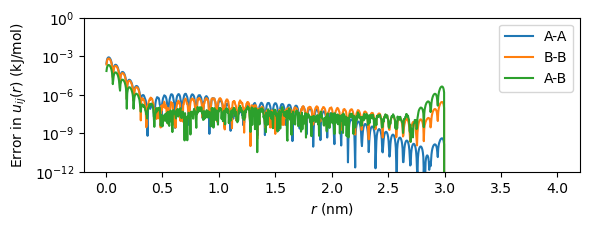

Average potential energy: 2.004955e+02 kJ/mol
Time for 100000 steps: 6.529 s


In [14]:
test_evaluate_potential(add_force_tabulated_c3d, n_table=5 * N_TABLE)
test_run_dynamics(add_force_tabulated_c3d, n_table=5 * N_TABLE)

## Tabulated potentials with `Discrete3DFunction`

To avoid the unnecessary interpolation along the $x$- and $y$-axes of the `Continuous3DFunction` that are only evaluated at integer values, we can use `Discrete3DFunction`s to hold precomputed polynomial spline coefficients, and use a custom force expression to evaluate the splines instead of relying on OpenMM to do so.  This also offers more flexibility over the spline functional form if desired; here, we use natural cubic splines just like the ones used internally by OpenMM in `Continuous3DFunction`, but a similar approach could be used to evaluate piecewise polynomials computed in other ways.

Specifically, here, we use SciPy's `CubicSpline` to compute piecewise polynomial coefficients for the spline interpolation.  The result is a SciPy `PPoly` object holding the coefficients.  For the polynomial piece between $r_k$ and $r_{k+1}$, SciPy returns coefficients $c_{3,k}$, $c_{2,k}$, $c_{1,k}$, and $c_{0,k}$ such that the polynomial can be written as $$f(r)=c_{0,k}+c_{1,k}(r-r_k)+c_{2,k}(r-r_k)^2+c_{3,k}(r-r_k)^3.$$  However, we will implement a functional form $$u_{ij}(r)=c_{0,ijk}+c_{1,ijk}(t-k)+c_{2,ijk}(t-k)^2+c_{3,ijk}(t-k)^3$$ where $t=(n_{\mathrm{table}}-1)r/r_{\mathrm{cut}}$ and $k=\lfloor t\rfloor$.  In this way, $t$ will range from $0$ to $n_{\mathrm{table}}-1$ as $r$ ranges from $0$ to $r_{\mathrm{cut}}$.  There are $n_{\mathrm{table}}$ evaluation points giving $n_{\mathrm{table}}-1$ polynomial pieces, so $k$ (the integer part of $t$) indexes the piece, and $t-k$ gives a value between $0$ and $1$ at which the piece is evaluated.  The `PPoly` coefficients are rescaled appropriately below to account for this.

In [15]:
def make_coeffs(n_table):
    # Get the n_table table points.  There will be n_table - 1 polynomial pieces between them, each of width delta.
    r_table = np.linspace(0.0, R_CUT.value_in_unit(u.nanometer), n_table) * u.nanometer
    delta = R_CUT.value_in_unit(u.nanometer) / (n_table - 1)

    # Prepare arrays for the cubic polynomial coefficients of the pieces.
    c_0, c_1, c_2, c_3 = np.zeros((4, 2, 2, n_table - 1))

    for i in range(2):
        for j in range(2):
            # Evaluate the potential and get the polynomial coefficients.
            u_table = [u_ij(r, i, j).value_in_unit(u.kilojoule_per_mole) for r in r_table]
            c_3_ij, c_2_ij, c_1_ij, c_0_ij = interp.CubicSpline(r_table.value_in_unit(u.nanometer), u_table, bc_type="natural").c

            # Rescale so that the coefficients describe polynomials on [0, 1] instead of [0, delta].
            c_0[i, j] = c_0_ij
            c_1[i, j] = c_1_ij * delta
            c_2[i, j] = c_2_ij * delta * delta
            c_3[i, j] = c_3_ij * delta * delta * delta
            
    return c_0, c_1, c_2, c_3

The custom force is a straightforward translation of the functional form described above.  An upper bound on $k$ ensures that no rounding errors will ever lead to coefficients beyond the bounds of the array being inadvertently accessed.

In [16]:
def add_force_tabulated_d3d(system, n_a, n_b, n_table):
    # Create the force.  We will use tabulated functions for each polynomial coefficient.
    # We rescale r from [0, R_CUT] to [0, n_table - 1], take the integer part as the piece index, and use the fractional part to evaluate the polynomial.
    r_scale = (n_table - 1) / R_CUT.value_in_unit(u.nanometer)
    force = openmm.CustomNonbondedForce(
        "c0(type1, type2, k) + t * (c1(type1, type2, k) + t * (c2(type1, type2, k) + t * c3(type1, type2, k))); "
        "t = s - k; "
        f"k = min(floor(s), {n_table - 1}); "
        f"s = r * {r_scale}"
    )
    force.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)
    force.setCutoffDistance(R_CUT)

    # Pass coefficient values into the force.  Here it is critical to specify column-major order!
    c_0, c_1, c_2, c_3 = make_coeffs(n_table)
    force.addTabulatedFunction("c0", openmm.Discrete3DFunction(2, 2, n_table - 1, c_0.flatten(order="F")))
    force.addTabulatedFunction("c1", openmm.Discrete3DFunction(2, 2, n_table - 1, c_1.flatten(order="F")))
    force.addTabulatedFunction("c2", openmm.Discrete3DFunction(2, 2, n_table - 1, c_2.flatten(order="F")))
    force.addTabulatedFunction("c3", openmm.Discrete3DFunction(2, 2, n_table - 1, c_3.flatten(order="F")))
    force.addPerParticleParameter("type")

    # Add particles.  Specify the appropriate type of each particle.
    for i in range(n_a):
        force.addParticle([0])
    for i in range(n_b):
        force.addParticle([1])

    system.addForce(force)

The results are effectively the same as for the `Continuous3DFunction` case, with slightly higher performance.  These benchmarks are not very realistic as the example systems and simulation times here are small; performance differences (as well as memory requirements) between the methods could vary depending on the particular nature and size of the system in question, numbers of particle types, table sizes, *etc.*

Maximum error for A-A: 2.844e-02 kJ/mol
Maximum error for B-B: 2.180e-02 kJ/mol
Maximum error for A-B: 6.495e-03 kJ/mol


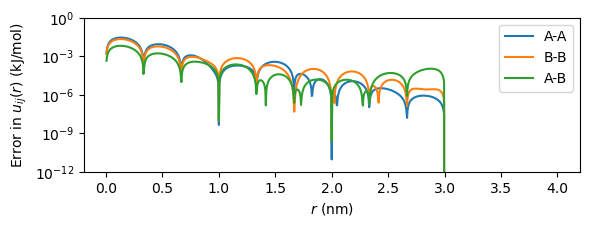

Average potential energy: 2.002654e+02 kJ/mol
Time for 100000 steps: 6.124 s


In [17]:
test_evaluate_potential(add_force_tabulated_d3d, n_table=N_TABLE)
test_run_dynamics(add_force_tabulated_d3d, n_table=N_TABLE)

Maximum error for A-A: 8.139e-04 kJ/mol
Maximum error for B-B: 6.644e-04 kJ/mol
Maximum error for A-B: 2.064e-04 kJ/mol


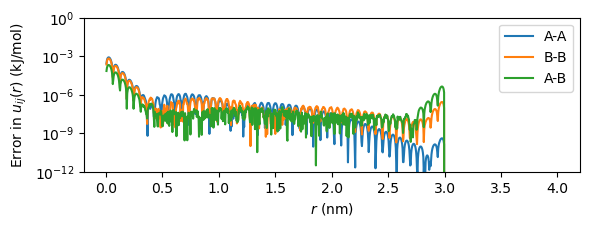

Average potential energy: 2.004201e+02 kJ/mol
Time for 100000 steps: 6.135 s


In [18]:
test_evaluate_potential(add_force_tabulated_d3d, n_table=5 * N_TABLE)
test_run_dynamics(add_force_tabulated_d3d, n_table=5 * N_TABLE)

## Notes and extensions to other potential types

These methods are not limited to pairwise potentials.  Bond, angle, dihedral, and any other kind of bonded interactions can be evaluated from tabulated values using `CustomCompoundBondForce` and `CustomCentroidBondForce`.  Note that `CustomBondForce`, `CustomAngleForce`, and `CustomTorsionForce` do not support tabulated functions, but their behavior can be fully replicated using `CustomCompoundBondForce` and the `distance(p1, p2)`, `angle(p1, p2, p3)`, and `dihedral(p1, p2, p3, p4)` functions supported in its custom energy expressions.

Instead of 3D functions taking pairs of particle types along with distance, 2D functions taking a bonded interaction type and a distance or angle can be used.  Use `CustomCompoundBondForce.addPerBondParameter` to add a type index to each bonded term, and use the type index to look up the potential values or coefficients in tables.  Pay close attention to the boundary conditions associated with each kind of bonded term:
* Typically, unlike pairwise potentials, bonds will not have cutoff distances beyond which the potential becomes 0.  You may wish to modify the custom energy expression using `select()` or another approach to define, *e.g.*, a linear extrapolation of the potential outside of the tabulated range.
* Angles should be in $[0,\pi]$ and the scaling of the piecewise polynomial coefficients should reflect this.
* Likewise, dihedrals should be in $[-\pi,\pi]$.  If using `Continuous2DFunction` to define different types of angle potentials, you should set `periodic=True` to ensure that there will be no discontinuity at the angle crossover point.  If using the discrete approach and solving for the polynomial coefficients with SciPy's `CubicSpline`, you will want to set `bc_type="periodic"` to get periodic boundary conditions instead.  See the documentation for more details on how to set up the coefficient arrays appropriately in these cases.

A final word of caution: the implementation described here that evaluates a reference potential functional form and used the resulting energy values directly for tabulation may not work well for all potentials.  For the soft-core Gaussian potentials used in this example, and similar soft-core potentials often used in coarse-grained modeling, this approach should generally be sufficient.  However, problems can arise for potentials with steep inner cores, and those that even approach infinite energy as $r\rightarrow0$ (such as the Lennard-Jones potential).  If fitting potentials like this to splines, a suitable inner cutoff distance should be chosen beyond which the potential should be, *e.g.*, a linear extrapolation from the inner cutoff to $r=0$ such that the potential remains finite and its derivative bounded.